In [1]:
#DEC model on Distributed pytorch. This one contains only CNN implementation. Please make sure to turn --cnn on.

%%writefile dist_goesnat20.py

import argparse
import copy
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import os
import pickle, gzip
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

from math import ceil
from random import Random
import traceback
import datetime
import socket
import torch.distributed as dist
from collections import OrderedDict

class Partition(object):

    def __init__(self, data, index):
        self.data = data
        self.index = index

    def __len__(self):
        return len(self.index)

    def __getitem__(self, index):
        data_idx = self.index[index]
        return self.data[data_idx]


class DataPartitioner(object):

    def __init__(self, data, sizes=[0.7, 0.2, 0.1], seed=1234):
        self.data = data
        self.partitions = []
        rng = Random()
        rng.seed(seed)
        data_len = len(data)
        indexes = [x for x in range(0, data_len)]
        rng.shuffle(indexes)

        for frac in sizes:
            part_len = int(frac * data_len)
            self.partitions.append(indexes[0:part_len])
            indexes = indexes[part_len:]

    def use(self, partition):
        return Partition(self.data, self.partitions[partition])

class AutoEncoder(torch.nn.Module):
    
    def __init__(self, auto_struct, auto_activation, n_features, n_channels, image_size, 
                                      kernel_size_and_stride, cnn):
        super().__init__()
        self.n_channels_in_image = n_channels
        self.image_size = image_size
        
        self.autonet = torch.nn.Sequential()
        self.cnn = cnn
        self.re_shape = []
        
        if cnn:
            self.cnn_autoencoder(auto_struct, kernel_size_and_stride, auto_activation, n_channels, image_size)
        else:
            self.autoencoder(n_features, auto_struct, auto_activation)
        
    def autoencoder(self, input_dim, auto_struct, activation):
        
        feature_in = input_dim
        auto_length = len(auto_struct)
        for i in range(auto_length):
            if i < int(auto_length / 2):
                self.autonet.add_module(f'encoder_{i+1}', torch.nn.Linear(feature_in, auto_struct[i]))
                self.autonet.add_module(f'encoder_{i+1}_act', activation)
            elif i == int(auto_length / 2):
                self.autonet.add_module('hidden', torch.nn.Linear(feature_in, auto_struct[i]))
            else:
                self.autonet.add_module(f'decoder_{auto_length - i}', torch.nn.Linear(feature_in, auto_struct[i]))
                self.autonet.add_module(f'decoder_{auto_length - i}_act', activation)
            feature_in = auto_struct[i]
        self.autonet.add_module(f'decoder_out', torch.nn.Linear(feature_in, input_dim))
        
    def cnn_autoencoder(self, auto_struct, kernels_size_and_stride, activation, n_channels_in_image, image_size):
        
        auto_length = len(auto_struct)
        n_units_previous = n_channels_in_image
        output_size_previous = image_size
        i = 0
    
        for (n_units, kernel) in zip(auto_struct, kernels_size_and_stride):
            kernel_size, kernel_stride = kernel
            if i < int(auto_length / 2):
                self.autonet.add_module(f'encoder_{i+1}', torch.nn.Conv2d(n_units_previous, n_units,
                                                                     kernel_size, kernel_stride))
                self.autonet.add_module(f'encoder_{i+1}_act', activation)
                
            elif i == int(auto_length / 2):
                #autonet.add_module(f'hidden', torch.nn.Conv2d(n_units_previous, n_units,
                 #                                                    kernel_size, kernel_stride))
                self.autonet.add_module('flatten', torch.nn.Flatten())
                fc_units = output_size_previous ** 2 * n_units_previous
                self.autonet.add_module('hidden', torch.nn.Linear(fc_units, n_units))
                self.autonet.add_module('fc_layer', torch.nn.Linear(n_units, fc_units))
                self.autonet.add_module('fc_layer_act', activation)
                i += 1
                continue
                
            elif i == int(auto_length / 2) + 1:
                i += 1
                self.re_shape.append(n_units)
                self.re_shape.append(output_size_previous)
                continue
                
            else:
                self.autonet.add_module(f'decoder_{auto_length - i}', torch.nn.ConvTranspose2d(n_units_previous, n_units,
                                                                     kernel_size, kernel_stride))
                self.autonet.add_module(f'decoder_{auto_length - i}_act', activation)
            output_size_previous = (output_size_previous - kernel_size) // kernel_stride + 1
            n_units_previous = n_units
            i += 1
        self.autonet.add_module(f'decoder_out', torch.nn.ConvTranspose2d(n_units_previous, n_channels_in_image, 3))
               
    def forward(self, X):
        
        #self.autonet.eval()
        #hidden_layer_index = int(len(self.autonet) / 2)
        #modulelist = list(self.autonet.features.modules())
        #for l in modulelist[:hidden_layer_index]:
         #   X = l(X)
        #hidden_out = copy.copy(X)
        #for l in modulelist[hidden_layer_index:]:
           # X_out = l(X)
        #X = self.autonet[:hidden_layer_index](X)
        #hidden_out = copy.copy(X)
        #X_out = self.autonet[hidden_layer_index:](X)
        #return X_out, hidden_out
        
        hidden_layer_index = int(len(self.autonet) / 2) + 1 if self.cnn else int(len(self.autonet) / 2)
        #for i in range(hidden_layer_index):
            #print(self.autonet[i].weight.size())
            #X = self.autonet[i](X)
            #print(X.shape)
        X = self.autonet[:hidden_layer_index](X)
        #X = torch.nn.Sequential(*(list(self.autonet.children())[:hidden_layer_index]))(X)
        hidden_out = copy.copy(X)
        if self.cnn:
            X_out = self.autonet[hidden_layer_index:hidden_layer_index+2](X)
            X_out = X_out.reshape(-1, self.re_shape[0], self.re_shape[1], self.re_shape[1])
            X_out = self.autonet[hidden_layer_index+2:](X_out)
        else:
            X_out = self.autonet[hidden_layer_index:](X)
        return X_out, hidden_out
        

class DeepEmbeddedCluster(torch.nn.Module):
    
    def __init__(self, X, auto_struct, auto_activation, n_clusters, alpha, n_channels, image_size, 
                kernel_size_and_stride, cnn, pretrain_weights_path):
    
        super().__init__()
        self.alpha = alpha
        self.pretrain_weights_path = pretrain_weights_path
        self.n_features = X.shape[1]
        
        self.autoencoder = AutoEncoder(auto_struct, auto_activation, self.n_features, n_channels, image_size, 
                                      kernel_size_and_stride, cnn)
        
        hidden_features = self.autoencoder.autonet.hidden.out_features
        
        self.soft_layer = torch.nn.Parameter(torch.Tensor(n_clusters, hidden_features))
        torch.nn.init.xavier_normal_(self.soft_layer.data)
        
    def pretrain(self):
        
        ae_pretrain(self.autoencoder)
        # original saved file with DataParallel
        state_dict = torch.load(self.pretrain_weights_path)
        # create new OrderedDict that does not contain `module.`
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
        # load params
        self.autoencoder.load_state_dict(new_state_dict)
        
    def forward(self, X):

        X_out, hidden_out = self.autoencoder(X)
        # cluster
        q = 1.0 / (1.0 + torch.sum(
            torch.pow(hidden_out.unsqueeze(1) - self.soft_layer, 2), 2) / self.alpha)
        q = q.pow((self.alpha + 1.0) / 2.0)
        q = (q.t() / torch.sum(q, 1)).t()
        return X_out, q

def target_distribution(q):
    
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()
        
def ae_pretrain(ae_model):
    
    aemodel = torch.nn.parallel.DistributedDataParallel(ae_model).float()
    trainloader, bsz = partition_dataset(Xtrain, args.pretrain_batch_size)
    num_batches = ceil(len(trainloader.dataset) / float(bsz))
    #trainloader = torch.utils.data.DataLoader(Xtrain, batch_size = args.pretrain_batch_size, shuffle = True)
    
    optimizer = torch.optim.Adam(aemodel.parameters(), lr = args.pretrain_lr)
    loss_func = torch.nn.MSELoss()
    
    error_trace = []
    
    for epoch in range(args.pretrain_epochs):
        epoch_error = 0.0
        for batch in trainloader:
            Xb = batch.to(device)
            optimizer.zero_grad()
            X_pred, hidden_pred = aemodel(Xb)
            error = loss_func(X_pred, Xb)
            epoch_error += error.item()
            error.backward()
            average_gradients(aemodel)
            optimizer.step()
        error_trace.append(epoch_error / num_batches)
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1} error {error_trace[-1]:.5f}')
            print('Rank ', dist.get_rank(), ', epoch ',
                  epoch, ': ', epoch_error / num_batches)
        torch.save(aemodel.state_dict(), args.pretrain_weights_path)
        
def DEC_train():
    
    torch.manual_seed(1234)
    time_start = time.time()
    delta_target = 0.001
    error_trace = []
    
    dec_model = DeepEmbeddedCluster(X = Xtrain, auto_struct = args.ae_structure, 
                                       auto_activation = ae_activation, n_clusters = args.clusters, 
                                       alpha = 1.0, n_channels = n_channels, image_size = image_size, 
                                       kernel_size_and_stride = kernel_stride, cnn = args.cnn, pretrain_weights_path = args.pretrain_weights_path)
    
    
    dec_model = dec_model.to(device)
    
    dec_model.pretrain()
    
    #trainloader = torch.utils.data.DataLoader(Xtrain, batch_size = args.dec_batch_size, shuffle = False)
    
    Xtr = Xtrain.to(device)
    X_out, hidden_out = dec_model.autoencoder(Xtr)
    
    kmeans = KMeans(n_clusters = args.clusters, n_init = 20)
    T_pred = kmeans.fit_predict(hidden_out.data.cpu().numpy())
    
    hidden_out = None
    X_out = None
    
    T_pred_prev = copy.copy(T_pred)
    dec_model.soft_layer.data = torch.tensor(kmeans.cluster_centers_).to(device)
    
    loss_func = torch.nn.MSELoss()
    loss_func_kl = torch.nn.KLDivLoss(reduction = 'batchmean')
    
    decmodel = torch.nn.parallel.DistributedDataParallel(dec_model).float()
    optimizer = torch.optim.Adam(decmodel.parameters(), lr = args.dec_lr)
    decmodel.train()
    
    for epoch in range(args.dectrain_epochs):
        epoch_error = 0.0
        if epoch % 50 == 0:
            _, q = decmodel(Xtr)
            q = q.data
            p = target_distribution(q)
            
            T_pred = q.cpu().numpy().argmax(1)
            delta_current = np.sum(T_pred != T_pred_prev).astype(np.float32) / T_pred.shape[0]
            T_pred_prev = T_pred
            
            if epoch > 0 and delta_current < delta_target:
                break
        inputlist = []
        for i, c in zip(Xtr, p):
            inputlist.append((i, c))
        trainloader, bsz = partition_dataset(inputlist, args.dec_batch_size)
        num_batches = ceil(len(trainloader.dataset) / float(bsz))
        #train_loader = torch.utils.data.DataLoader(inputlist, batch_size = args.dec_batch_size, shuffle = False)
        for batch in trainloader:
            Xb, pb = batch
            Xb = Xb.to(device)
            X_out, qb = decmodel(Xb)
            reconst_error = loss_func(X_out, Xb)
            kl_error = loss_func_kl(qb.log(), pb)
            error = args.gamma * kl_error + reconst_error
            epoch_error += error.item()
            optimizer.zero_grad()
            error.backward()
            average_gradients(decmodel)
            optimizer.step()
        error_trace.append(epoch_error / num_batches)
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1} error {error_trace[-1]:.5f}')
            print('Rank ', dist.get_rank(), ', epoch ',
                  epoch, ': ', epoch_error / num_batches)
        
    
    _, qt = decmodel(Xtr)
    qt = qt.data
    qn = qt.cpu().numpy()
    train_pred = qn.argmax(1)
    
    training_time = time.time() - time_start
    
    np.savez('trainres', clpred = train_pred, qout = qn, err = error_trace, traintime = training_time)
     
    #print(f'Training accuracy: {normalized_mutual_info_score(Ttrain, train_pred)}')
    
    print('All done.')
            
def _standardization_param_set(X, Xmeans, Xstds, XstdsFixed, XstdsConst):
        
    if Xmeans is None:
        Xmeans = X.mean(axis = 0)
        Xstds = X.std(axis = 0)
        XstdsConst = Xstds == 0
        XstdsFixed = copy.copy(Xstds)
        XstdsFixed[XstdsConst] = 1
        
    return Xmeans, Xstds, XstdsFixed, XstdsConst
            
def _standardizeX(X, Xmeans, Xstds, XstdsFixed, XstdsConst):
        
    X_standardized = (X - Xmeans) / XstdsFixed
    X_standardized[:, XstdsConst] = 0.0
    return X_standardized
    
def _unstandardizeX(Xs):
        
    return (Xs * Xstds) + Xmeans

""" Gradient averaging. """
def average_gradients(model):
    size = float(dist.get_world_size())
    for param in model.parameters():
        dist.all_reduce(param.grad.data, op=dist.reduce_op.SUM)
        param.grad.data /= size
    
def partition_dataset(X, batch_size):
        
    dataset = X
    size = dist.get_world_size()
    bsz = batch_size / float(size)
    partition_sizes = [1.0 / size for _ in range(size)]
    partition = DataPartitioner(dataset, partition_sizes)
    partition = partition.use(dist.get_rank())
    train_loader = torch.utils.data.DataLoader(partition, batch_size=int(bsz), shuffle=True)
    return train_loader, bsz
    
def setup(rank, world_size, backend):
    os.environ['MASTER_ADDR'] = 'saturn'
    os.environ['MASTER_PORT'] = '31350'
    
    # initialize the process group
    dist.init_process_group(backend, rank = int(rank), 
                            world_size = int(world_size),  
                            init_method = 'tcp://saturn:31349',
                            timeout = datetime.timedelta(weeks = 120))
    torch.manual_seed(42)
    

if __name__ == '__main__':
    
    try:
    
        print('Running ' + sys.argv[0] + ' ...')
        argv_parser = argparse.ArgumentParser()
        argv_parser.add_argument('--rank', nargs = '?', type = int, default = None)
        argv_parser.add_argument('--world', nargs = '?', type = int, default = None)
        argv_parser.add_argument('--datafile', nargs = '?')
        argv_parser.add_argument('--ae_structure', nargs = '*', type = int, default = [500, 500, 200, 10, 200, 500, 500])
        argv_parser.add_argument('--kernel_stride', nargs = '*', type = list, default = None)
        argv_parser.add_argument('--ae_activation', nargs = '?', default = 'relu')
        argv_parser.add_argument('--clusters', nargs = '?', type = int, default = 10)
        argv_parser.add_argument('--pretrain_epochs', nargs = '?', type = int, default = 200)
        argv_parser.add_argument('--pretrain_lr', nargs = '?', type = float, default = 0.001)
        argv_parser.add_argument('--pretrain_batch_size', nargs = '?', type = int, default = 100)
        argv_parser.add_argument('--dectrain_epochs', nargs = '?', type = int, default = 200)
        argv_parser.add_argument('--dec_lr', nargs = '?', type = float, default = 0.001)
        argv_parser.add_argument('--dec_batch_size', nargs = '?', type = int, default = 100)
        argv_parser.add_argument('--gpu', nargs = '?', type = bool, default = False)
        argv_parser.add_argument('--cnn', nargs = '?', type = bool, default = False)
        argv_parser.add_argument('--pretrain_weights_path', type=str, default='./ae_goes')
        argv_parser.add_argument('--gamma', type=float, default=0.1)

        args = argv_parser.parse_args()
        
        gpu = False
        
        if args.gpu and torch.cuda.is_available():
            gpu = True
    
        device = torch.device("cuda" if gpu else "cpu")
        backend = "nccl" if gpu else "gloo"
        
        print(gpu, device, backend)

        setup(args.rank, args.world, backend)
        print(socket.gethostname()+": Setup completed.")

        activation_dict = {'relu': torch.nn.ReLU(True), 'tanh': torch.nn.Tanh(), 'sigmoid': torch.nn.Sigmoid()}
        ae_activation = activation_dict[args.ae_activation]
        
        with np.load('data/npnatlantic.npz') as f:
            train_set = f['natlantic20']
        
        Xtrain = train_set

        Xmeans = None
        Xstds = None
        XstdsFixed = None
        XstdsConst = None

        n_channels = None
        image_size = None
        kernel_stride = None

        if args.cnn:

            n_channels = Xtrain.shape[1]
            image_size = Xtrain.shape[2]

            kernel_stride = [list(map(int, item)) for item in args.kernel_stride]

        Xmeans, Xstds, XstdsFixed, XstdsConst = _standardization_param_set(Xtrain, Xmeans, Xstds, XstdsFixed, XstdsConst)
        Xtrain = _standardizeX(Xtrain, Xmeans, Xstds, XstdsFixed, XstdsConst)
        Xtrain = torch.tensor(Xtrain).type(torch.FloatTensor)
        print(Xtrain.shape)
        print(n_channels)
        print(args.cnn)
    
        DEC_train()
        
    except Exception as e:
        traceback.print_exc()
        sys.exit(3)

Overwriting dist_goesnat20.py


In [5]:
# Load the training results from npz file

import numpy as np

res = np.load('trainres.npz')
    
qo = res['qout']
tp = res['clpred']
tt = res['traintime']
ee = res['err']

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 121464 samples in 0.070s...
[t-SNE] Computed neighbors for 121464 samples in 4.182s...
[t-SNE] Computed conditional probabilities for sample 1000 / 121464
[t-SNE] Computed conditional probabilities for sample 2000 / 121464
[t-SNE] Computed conditional probabilities for sample 3000 / 121464
[t-SNE] Computed conditional probabilities for sample 4000 / 121464
[t-SNE] Computed conditional probabilities for sample 5000 / 121464
[t-SNE] Computed conditional probabilities for sample 6000 / 121464
[t-SNE] Computed conditional probabilities for sample 7000 / 121464
[t-SNE] Computed conditional probabilities for sample 8000 / 121464
[t-SNE] Computed conditional probabilities for sample 9000 / 121464
[t-SNE] Computed conditional probabilities for sample 10000 / 121464
[t-SNE] Computed conditional probabilities for sample 11000 / 121464
[t-SNE] Computed conditional probabilities for sample 12000 / 121464
[t-SNE] Computed conditional probab

[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.413399
[t-SNE] KL divergence after 300 iterations: 5.202197


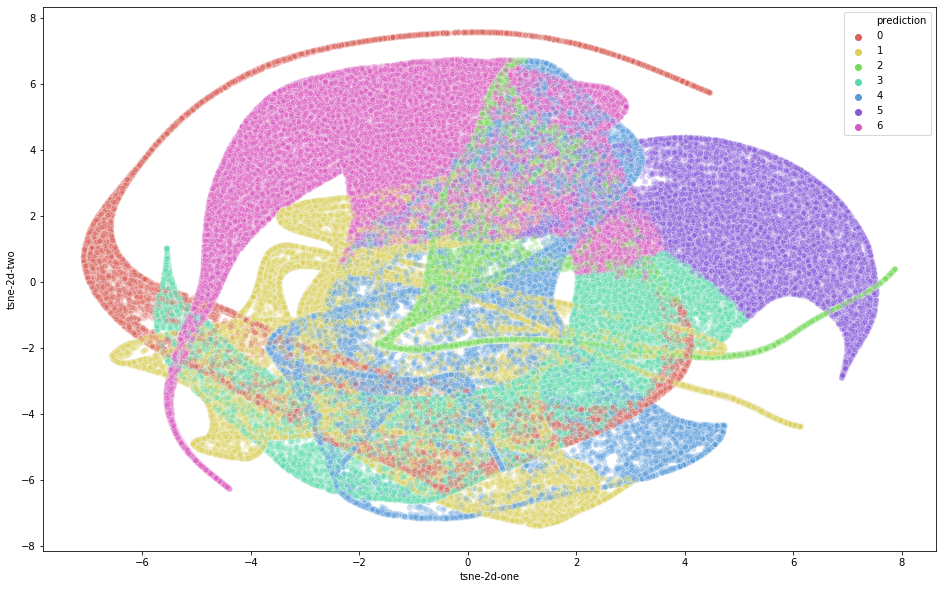

In [7]:
#Plot TSNE of the training results

from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
import numpy as np

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(qo)
        
data = pandas.DataFrame(tsne_results)
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]
data['prediction'] = tp
colors = np.unique(tp)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="prediction",
    palette=sns.color_palette("hls", len(colors)),
    data=data,
    legend="full",
    alpha=0.3
    )

Text(0, 0.5, 'Error')

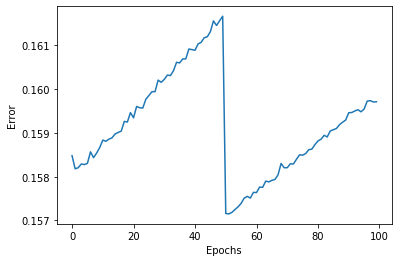

In [8]:
#Plot KL-Div error trace

import matplotlib.pyplot as plt

plt.plot(ee)
plt.xlabel('Epochs')
plt.ylabel('Error')

In [9]:
# Training Time
print('Training time: ', tt)

Training time:  37467.83247113228
